# 第六模块 (2)：模型评估

本 Notebook 基于 Part 1 生成的评测数据集，对 RAG 系统进行多维度模型评估与消融实验：

### 评估维度设计

传统 RAG 系统常用 Recall@K、Precision@K 等指标进行评估，但这些指标不适用于酒店评论场景，原因在于：
- **无标准答案**: 评论是多位住客的主观体验，不存在唯一标准答案，需综合多条评论给出参考性回复
- **检索复杂性**: 即使一条评论完美回答了用户的问题也未必被采用，需综合考虑其内容质量和时效性等因素
- **模糊意图处理**: 用户的模糊提问应被多维度拆解回答，而非简单给出答案，这一过程可能引入看似无关但有效的信息
- **场景区分度低**: 酒店评论属日常场景，若对每次回复进行独立的绝对评分，评估模型给出的分数往往相近，难以有效区分优劣

因此，设计以下 **6 个评估维度 + 1 个综合维度**，采用**排名制**（同一问题下多配置横向对比排序）而非绝对评分制：

| 维度 | 说明 |
|------|------|
| **意图理解度** | 是否正确理解了用户提问的核心意图，并对模糊意图进行了合理的多维度展开 |
| **内容覆盖度** | 回答是否覆盖了与问题相关的主要方面，信息是否充分且具体 |
| **观点平衡性** | 是否客观呈现了正面与负面评价，未过度偏向某一方 |
| **引用溯源性** | 回答中的关键信息是否能溯源到具体评论，引用是否准确且无幻觉 |
| **时效合理性** | 是否合理处理了评论的时间分布，对时效性敏感问题是否优先引用近期评论 |
| **表达专业度** | 回答是否条理清晰、语气专业亲切、长度适中、无冗余重复 |
| **综合表现** | 基于以上六个维度的整体权衡 |

### 消融实验设计

单独关闭一路召回往往效果不显著（其他通路会补位），因此采用**分组消融**策略，放大对比差异：

| 配置名称 | 关闭组件 | 探究目标 |
|----------|----------|----------|
| `full` | 无 | 完整模型性能（基线） |
| `no_expansion` | 意图扩展 | 意图扩展对多维度理解的作用 |
| `only_bm25` | 向量 + 反向 + HyDE + 摘要 | 纯文本检索的性能下限 |
| `only_vector` | 文本 + 反向 + HyDE + 摘要 | 纯向量检索的性能下限 |
| `no_enhancement` | 反向 + HyDE | 增强召回通路的边际贡献 |
| `no_summary` | 摘要 | 类别摘要信息的影响 |
| `no_rerank` | 重排 | 多因子重排模块的作用 |
| `minimal` | 意图扩展 + 反向 + HyDE + 摘要 + 重排 | 最简混合检索的性能下限 |

## 1. 环境配置

In [1]:
import os
import json
import time
import random
import numpy as np
from pathlib import Path
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from concurrent.futures import ThreadPoolExecutor, as_completed
from lib import HotelReviewRAG, LLMClient

In [2]:
# 检查环境变量
required_env = {
    "DASHSCOPE_API_KEY": os.getenv("DASHSCOPE_API_KEY"),
    "DASHVECTOR_API_KEY": os.getenv("DASHVECTOR_API_KEY"),
    "DASHVECTOR_HOTEL_ENDPOINT": os.getenv("DASHVECTOR_HOTEL_ENDPOINT"),
}

missing = [k for k, v in required_env.items() if not v]
if missing:
    raise EnvironmentError(f"缺少环境变量: {', '.join(missing)}")

print("环境变量检测成功:")
for key, value in required_env.items():
    print(f"- {key}: {value[:10]}...{value[-4:]}")

环境变量检测成功:
- DASHSCOPE_API_KEY: sk-5540c66...f37a
- DASHVECTOR_API_KEY: sk-W6G93uB...7EDE
- DASHVECTOR_HOTEL_ENDPOINT: vrs-cn-w5g....com


In [3]:
# 项目路径配置
PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"
EVAL_DATA_DIR = DATA_DIR / "evaluation"

# 时间基准
EVAL_TODAY = datetime(2025, 4, 18)

# 评估模型
EVAL_MODEL = "qwen3-max"
eval_llm = LLMClient(api_key=required_env["DASHSCOPE_API_KEY"], model=EVAL_MODEL, json=True)

print(f"项目根目录: {PROJECT_ROOT}")
print(f"评测数据目录: {EVAL_DATA_DIR}")
print(f"评估模型: {EVAL_MODEL}")
print(f"评估日期: {EVAL_TODAY.strftime('%Y-%m-%d')}")

项目根目录: C:\Users\22418\Desktop\Scorpio\复旦\课程\大三下\酒店评论
评测数据目录: C:\Users\22418\Desktop\Scorpio\复旦\课程\大三下\酒店评论\data\evaluation
评估模型: qwen3-max
评估日期: 2025-04-18


In [4]:
# 加载评测数据集（前 90 个问题，排除包含房型的最后 10 个）
with open(EVAL_DATA_DIR / "eval_set.json", "r", encoding="utf-8") as f:
    all_questions = json.load(f)

eval_questions = [q for q in all_questions if q["question_id"] <= 90]

print(f"加载问题总数: {len(all_questions)} 个")
print(f"评估问题数量: {len(eval_questions)} 个（排除最后 10 个房型问题）")

# 统计问题类型分布
type_counts = {}
for q in eval_questions:
    qtype = q["question_type"]
    type_counts[qtype] = type_counts.get(qtype, 0) + 1

print(f"问题类型分布:")
for qtype, count in type_counts.items():
    print(f"  • {qtype}: {count} 个")

加载问题总数: 100 个
评估问题数量: 90 个（排除最后 10 个房型问题）
问题类型分布:
  • structured: 70 个
  • ambiguous: 10 个
  • temporal_clear: 5 个
  • temporal_implied: 5 个


In [5]:
# 初始化 RAG 系统
rag_system = HotelReviewRAG(
    api_key=required_env["DASHSCOPE_API_KEY"],
    dashvector_api_key=required_env["DASHVECTOR_API_KEY"],
    dashvector_endpoint=required_env["DASHVECTOR_HOTEL_ENDPOINT"],
    data_dir=DATA_DIR
)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\22418\AppData\Local\Temp\jieba.cache
Loading model cost 0.587 seconds.
Prefix dict has been built successfully.


倒排索引已加载


## 2. 定义消融实验配置

In [6]:
ABLATION_CONFIGS = {
    "full": {
        "description": "完整模型性能",
        "params": {}
    },
    "no_expansion": {
        "description": "关闭意图扩展",
        "params": {"enable_expansion": False}
    },
    "only_bm25": {
        "description": "召回通路仅保留文本召回",
        "params": {"enable_vector": False, "enable_reverse": False, "enable_hyde": False, "enable_summary": False}
    },
    "only_vector": {
        "description": "召回通路仅保留向量召回",
        "params": {"enable_bm25": False, "enable_reverse": False, "enable_hyde": False, "enable_summary": False}
    },
    "no_enhancement": {
        "description": "关闭反向+HyDE",
        "params": {"enable_reverse": False, "enable_hyde": False}
    },
    "no_summary": {
        "description": "关闭摘要召回",
        "params": {"enable_summary": False}
    },
    "no_rerank": {
        "description": "关闭重排模块",
        "params": {"enable_ranking": False}
    },
    "minimal": {
        "description": "最简混合检索（文本+向量，无扩展/增强/摘要/重排）",
        "params": {"enable_expansion": False, "enable_reverse": False, "enable_hyde": False, "enable_summary": False, "enable_ranking": False}
    }
}

## 3. 批量生成 RAG 回复

In [7]:
def run_single_query(rag_system, question: dict, config_params: dict) -> dict:
    """
    对单个问题执行 RAG 查询
    
    返回:
        包含问题信息、回复、引用等的完整结果
    """
    try:
        result = rag_system.query(
            user_query=question["question"],
            print_response=False,
            today=EVAL_TODAY,
            **config_params
        )
        
        # 提取引用的评论信息
        cited_comments = []
        for c in result["references"]["comments"]:
            cited_comments.append({
                "comment_id": c["comment_id"],
                "comment": c["comment"],
                "publish_date": c["metadata"]["publish_date"],
                "score": c["metadata"]["score"],
                "room_type": c["metadata"]["room_type"],
                "rrf_rank": c["rrf_rank"],
                "final_rank": c.get("final_rank"),
                "rerank_score": c.get("rerank_score")
            })
        
        # 提取引用的摘要信息
        cited_summaries = []
        for s in result["references"]["summaries"]:
            cited_summaries.append({
                "category": s["metadata"]["category"],
                "keywords": s["metadata"]["keywords"],
                "comment_count": s["metadata"]["comment_count"],
                "summary": s["summary"]
            })
        
        return {
            "question_id": question["question_id"],
            "question": question["question"],
            "question_type": question["question_type"],
            "metadata": question["metadata"],
            "response": result["response"],
            "cited_comments": cited_comments,
            "cited_summaries": cited_summaries,
            "intent_expansion": result["query_processing"]["intent_expansion"],
            "intent_detection": result["query_processing"]["intent_detection"],
            "timing": {
                "total": result["timing"]["total"],
                "generation": result["timing"]["generation"]
            },
            "error": None
        }
    
    except Exception as e:
        return {
            "question_id": question["question_id"],
            "question": question["question"],
            "question_type": question["question_type"],
            "metadata": question["metadata"],
            "response": "",
            "cited_comments": [],
            "cited_summaries": [],
            "intent_expansion": None,
            "intent_detection": None,
            "timing": {"total": 0, "generation": 0},
            "error": str(e)
        }

In [8]:
def run_ablation_experiment(rag_system, questions: list[dict], config_name: str, config_params: dict, max_workers: int = 16) -> list[dict]:
    """
    并行执行单个消融实验配置下的所有问题
    
    参数:
        rag_system: RAG 系统实例
        questions: 评测问题列表
        config_name: 配置名称
        config_params: 传给 query() 的参数
        max_workers: 并行线程数
    
    返回:
        所有问题的回复结果列表
    """
    results = [None] * len(questions)
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_idx = {
            executor.submit(run_single_query, rag_system, q, config_params): i
            for i, q in enumerate(questions)
        }
        
        with tqdm(total=len(questions), desc=f"[{config_name}]") as pbar:
            for future in as_completed(future_to_idx):
                idx = future_to_idx[future]
                results[idx] = future.result()
                pbar.update(1)
    
    # 统计错误数
    errors = [r for r in results if r["error"]]
    if errors:
        print(f"  {len(errors)} 个问题执行失败")
        for e in errors:
            print(f"    Q{e['question_id']}: {e['error'][:100]}")
    
    return results

In [9]:
# 执行所有消融实验
all_experiment_results = {}

for config_name, config in ABLATION_CONFIGS.items():
    
    # 检查是否已有缓存结果
    cache_file = EVAL_DATA_DIR / f"responses_{config_name}.json"
    if cache_file.exists():
        with open(cache_file, "r", encoding="utf-8") as f:
            all_experiment_results[config_name] = json.load(f)
        print(f"  从缓存加载: {cache_file.name}（{len(all_experiment_results[config_name])} 条）")
        continue
    
    start_time = time.time()
    results = run_ablation_experiment(
        rag_system, eval_questions, config_name, config["params"], max_workers=16
    )
    elapsed = time.time() - start_time
    
    # 保存中间结果
    with open(cache_file, "w", encoding="utf-8") as f:
        json.dump(results, f, ensure_ascii=False, indent=2)
    
    all_experiment_results[config_name] = results
    
    success_count = sum(1 for r in results if not r["error"])
    avg_time = np.mean([r["timing"]["total"] for r in results if not r["error"]])
    print(f"  完成: {success_count}/{len(results)} 成功, 平均耗时 {avg_time:.2f}s, 总耗时 {elapsed:.1f}s")
    print(f"  已保存: {cache_file.name}")

[full]:   0%|          | 0/90 [00:00<?, ?it/s]

  完成: 90/90 成功, 平均耗时 30.39s, 总耗时 184.5s
  已保存: responses_full.json


[no_expansion]:   0%|          | 0/90 [00:00<?, ?it/s]

  完成: 90/90 成功, 平均耗时 30.24s, 总耗时 197.2s
  已保存: responses_no_expansion.json


[only_bm25]:   0%|          | 0/90 [00:00<?, ?it/s]

  完成: 90/90 成功, 平均耗时 25.73s, 总耗时 158.9s
  已保存: responses_only_bm25.json


[only_vector]:   0%|          | 0/90 [00:00<?, ?it/s]

  完成: 90/90 成功, 平均耗时 26.89s, 总耗时 169.5s
  已保存: responses_only_vector.json


[no_enhancement]:   0%|          | 0/90 [00:00<?, ?it/s]

  完成: 90/90 成功, 平均耗时 30.22s, 总耗时 183.7s
  已保存: responses_no_enhancement.json


[no_summary]:   0%|          | 0/90 [00:00<?, ?it/s]

  完成: 90/90 成功, 平均耗时 30.44s, 总耗时 186.3s
  已保存: responses_no_summary.json


[no_rerank]:   0%|          | 0/90 [00:00<?, ?it/s]

  完成: 90/90 成功, 平均耗时 30.52s, 总耗时 182.2s
  已保存: responses_no_rerank.json


[minimal]:   0%|          | 0/90 [00:00<?, ?it/s]

  完成: 90/90 成功, 平均耗时 25.90s, 总耗时 159.0s
  已保存: responses_minimal.json


## 4. 定义排名评估提示词与评分器

**评估方法**：排名制（Ranking-based）

对于每个问题，将全部 8 个消融配置的回复**打乱顺序匿名呈现**给评估模型，要求在每个维度上对所有回复进行排名（1=最优，8=最差）

In [10]:
def build_ranking_prompt(question: str, responses: dict[str, dict], config_order: list[str]) -> str:
    """
    构建排名评估提示词
    
    参数:
        question: 用户原始问题
        responses: {config_name: result_dict} 全部配置的回复
        config_order: 打乱后的配置顺序（匿名展示）
    
    返回:
        排名评估提示词
    """
    # 构建各回复的展示内容（匿名：系统 A/B/C/...）
    labels = [chr(65 + i) for i in range(len(config_order))]  # A, B, C, ...
    responses_block = ""
    
    for label, config_name in zip(labels, config_order):
        r = responses[config_name]
        if r["error"]:
            responses_block += f"\n系统{label}\n[该系统未能生成回复]\n"
            continue
        
        # 回复正文
        resp_text = r["response"]
        
        # 附上该系统引用的评论和摘要
        cited_info = ""
        if r.get("cited_comments"):
            cited_info += "\n[该系统检索到的用户评论]\n"
            for ci, c in enumerate(r["cited_comments"], 1):
                cited_info += f"评论{ci}（发布于{c['publish_date']}，评分: {c['score']}分，房型: {c['room_type']}）：\n{c['comment']}\n\n"
        if r.get("cited_summaries"):
            cited_info += "[该系统检索到的评论摘要]\n"
            for s in r["cited_summaries"]:
                cited_info += f"[{s['category']}类别摘要]\n关键词: {s['keywords']}\n内容: {s['summary']}\n\n"
        
        responses_block += f"\n系统{label}\n{resp_text}\n{cited_info}"
    
    n = len(config_order)
    
    prompt = f"""
你是一位严格的酒店问答 RAG 系统评估专家。
下面给出了同一个用户问题在 {n} 个不同系统配置下生成的回复。请在每个评估维度上，对这 {n} 个回复**从优到劣排序**。

【评估背景】
- 基于真实住客评论的酒店智能客服系统（广州花园酒店）
- 用户提问时间为 2025年4月18日
- 各系统从同一评论知识库中检索信息并生成回复，但检索策略不同，因此回复质量有差异
- 评论是住客主观体验，没有唯一标准答案；好的回答应综合多条评论给出全面客观的参考意见
- 每个系统的回复后附有其检索到的原始评论和摘要，供你核查引用是否准确、有无幻觉（回复中出现但原始评论中不存在的信息）
- 注意区分「用户评论」（单条住客真实评论）和「评论摘要」（系统从大量评论中预先提炼的概括性信息）

【用户问题】
{question}

【各系统的回复】
{responses_block}

【评估维度说明】

1. **意图理解度** — 是否真正理解了用户深层需求（场景约束、隐含诉求），而非仅按字面关键词回答。泛化的通用回答应排在针对性回答之后。
2. **内容覆盖度** — 是否充分覆盖问题涉及的各方面，信息是否具体。使用「设施齐全」「服务不错」等空泛表述而无细节支撑的应靠后排。
3. **观点平衡性** — 是否客观呈现正反评价。只说好话或只说坏话的排在后面。用「多数住客认为」但无足够证据支撑的应靠后排。
4. **引用溯源性** — 关键信息是否标注了出处（评论编号）。请对照各系统检索到的原始评论，核查回复中的引用是否准确。出现无中生有的信息（回复中有但原始评论中找不到对应来源）直接排末位。
5. **时效合理性** — 是否合理利用评论时间信息。请对照各系统检索到的评论发布日期判断。对于时效性敏感的问题，优先使用近期（2025年）评论的排前面；大量引用2023年及更早评论回答「现在」情况的排后面。对无时效性需求的问题，主要看有无引用过时信息造成误导。
6. **表达专业度** — 结构是否清晰、语言是否精炼、有无冗余重复或过度客套。大段照搬评论原文、堆砌模板话术的应靠后排。

【排名规则】
- 每个维度独立排名，1 = 最优，{n} = 最差
- 不允许并列：即使两个系统表现接近，也必须分出先后
- 未能生成回复的系统自动排末位
- 综合排名（overall）基于你对六个维度的整体权衡，不需要是各维度排名的简单平均

【输出格式】
严格以 JSON 格式输出，值为系统标签按排名排列的数组（第一个最优，最后一个最差）。不要有任何额外说明：
{{
    "intent_understanding": ["{labels[0]}", "{labels[1]}", ...],
    "content_coverage": ["{labels[0]}", "{labels[1]}", ...],
    "opinion_balance": ["{labels[0]}", "{labels[1]}", ...],
    "traceability": ["{labels[0]}", "{labels[1]}", ...],
    "temporal_awareness": ["{labels[0]}", "{labels[1]}", ...],
    "expression_quality": ["{labels[0]}", "{labels[1]}", ...],
    "overall": ["{labels[0]}", "{labels[1]}", ...]
}}
"""
    return prompt

In [11]:
def rank_single_question(eval_llm: LLMClient, question_id: int, question: str, all_results: dict[str, list[dict]]) -> dict:
    """
    对单个问题的所有配置回复进行排名评估
    
    参数:
        eval_llm: 评估用 LLM
        question_id: 问题 ID
        question: 用户问题
        all_results: {config_name: [result_list]} 全部实验结果
    
    返回:
        {question_id, config_order, label_to_config, rankings, error}
    """
    config_names = list(all_results.keys())
    
    # 收集该问题在各配置下的回复
    responses = {}
    for config_name in config_names:
        
        # 找到对应 question_id 的结果
        result = None
        for r in all_results[config_name]:
            if r["question_id"] == question_id:
                result = r
                break
        if result is None:
            result = {"question_id": question_id, "error": "未找到结果", "response": ""}
        responses[config_name] = result
    
    # 打乱顺序（匿名化）
    config_order = config_names.copy()
    random.shuffle(config_order)
    labels = [chr(65 + i) for i in range(len(config_order))]
    label_to_config = {label: config for label, config in zip(labels, config_order)}
    
    prompt = build_ranking_prompt(
        question=question,
        responses=responses,
        config_order=config_order
    )
    
    for attempt in range(3):
        try:
            response = eval_llm.generate(prompt, temperature=0.1)
            response = response.replace('```json', '').replace('```', '').strip()
            rankings_raw = json.loads(response)
            
            # 验证格式
            expected_dims = [
                "intent_understanding", "content_coverage", "opinion_balance",
                "traceability", "temporal_awareness", "expression_quality", "overall"
            ]
            
            for dim in expected_dims:
                assert dim in rankings_raw, f"缺少维度: {dim}"
                ranked_labels = rankings_raw[dim]
                assert len(ranked_labels) == len(config_order), (f"{dim}: 期望 {len(config_order)} 个排名，实际 {len(ranked_labels)}")
                for lbl in ranked_labels:
                    assert lbl in label_to_config, f"{dim}: 非法标签 {lbl}"
            
            # 将标签排名转换为 config_name -> rank
            rankings = {}
            for dim in expected_dims:
                dim_ranking = {}
                for rank_pos, label in enumerate(rankings_raw[dim], 1):
                    config_name = label_to_config[label]
                    dim_ranking[config_name] = rank_pos
                rankings[dim] = dim_ranking
            
            return {
                "question_id": question_id,
                "config_order": config_order,
                "label_to_config": label_to_config,
                "rankings": rankings,
                "error": None
            }
        
        except Exception as e:
            if attempt < 2:
                time.sleep(2)
                continue
            return {
                "question_id": question_id,
                "config_order": config_order,
                "label_to_config": label_to_config,
                "rankings": None,
                "error": f"排名失败: {str(e)}"
            }

## 5. 执行排名评估

In [12]:
# 每个问题一次调用，LLM 同时对比全部配置的回复并排名
RANKING_CACHE = EVAL_DATA_DIR / "ranking_results.json"

if RANKING_CACHE.exists():
    with open(RANKING_CACHE, "r", encoding="utf-8") as f:
        ranking_results = json.load(f)
    print(f"从缓存加载排名结果: {len(ranking_results)} 条")

else:
    ranking_results = [None] * len(eval_questions)
    
    with ThreadPoolExecutor(max_workers=16) as executor:
        future_to_idx = {}
        for i, q in enumerate(eval_questions):
            future = executor.submit(rank_single_question, eval_llm, q["question_id"], q["question"], all_experiment_results)
            future_to_idx[future] = i
        
        with tqdm(total=len(eval_questions), desc="排名评估") as pbar:
            for future in as_completed(future_to_idx):
                idx = future_to_idx[future]
                ranking_results[idx] = future.result()
                pbar.update(1)
    
    # 保存
    with open(RANKING_CACHE, "w", encoding="utf-8") as f:
        json.dump(ranking_results, f, ensure_ascii=False, indent=2)
    print(f"排名结果已保存: {RANKING_CACHE.name}")

# 统计
success = sum(1 for r in ranking_results if r and r["rankings"] is not None)
print(f"评估成功率: {success}/{len(ranking_results)}")

排名评估:   0%|          | 0/90 [00:00<?, ?it/s]

排名结果已保存: ranking_results.json
评估成功率: 90/90


## 6. 结果可视化

对消融实验结果进行可视化分析

可视化内容：
- (a) 8 个实验配置的综合排名对比
- (b) 各配置在 7 个评估维度上的排名热力图
- (c) 结构化问题 vs. 模糊性问题综合排名对比
- (d) 各组件贡献度分析（移除后的排名退化程度）

In [13]:
# 维度名称映射
DIM_NAMES = {
    "intent_understanding": "意图理解度",
    "content_coverage": "内容覆盖度",
    "opinion_balance": "观点平衡性",
    "traceability": "引用溯源性",
    "temporal_awareness": "时效合理性",
    "expression_quality": "表达专业度",
    "overall": "综合表现"
}
DIMENSIONS = list(DIM_NAMES.keys())
config_names = list(ABLATION_CONFIGS.keys())

# 全局绘图风格配置
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "DejaVu Sans", "Helvetica"],
    "font.size": 10,
    "axes.labelsize": 11,
    "axes.titlesize": 12,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# 配置显示名称
CONFIG_DISPLAY = {
    "full": "Full Model",
    "no_expansion": "\u2212 Expansion",
    "only_bm25": "BM25 Only",
    "only_vector": "Vector Only",
    "no_enhancement": "\u2212 Reverse & HyDE",
    "no_summary": "\u2212 Summary",
    "no_rerank": "\u2212 Reranking",
    "minimal": "Minimal"
}

# 维度显示名称（多行标签，适配热力图 x 轴）
DIM_DISPLAY = [
    "Intent\nUnderstand", "Content\nCoverage", "Opinion\nBalance",
    "Citation\nTraceability", "Temporal\nAwareness", "Expression\nQuality", "Overall"
]

# 配色方案：蓝色系（完整/近完整模型）；红色系（大幅简化模型）
CONFIG_COLORS = {
    "full": "#2166AC",
    "no_enhancement": "#4393C3",
    "no_expansion": "#92C5DE",
    "no_summary": "#D1E5F0",
    "only_vector": "#FDDBC7",
    "only_bm25": "#F4A582",
    "no_rerank": "#D6604D",
    "minimal": "#B2182B"
}

def get_question_type(qid: int) -> str:
    """根据问题 ID 返回问题类型"""
    if qid <= 70:
        return "structured"
    elif qid <= 80:
        return "ambiguous"
    elif qid <= 85:
        return "temporal_clear"
    else:
        return "temporal_implied"

# 计算各配置综合排名并排序
overall_avg_ranks = {}
for config in config_names:
    ranks = [
        r["rankings"]["overall"][config]
        for r in ranking_results
        if r and r["rankings"] and "overall" in r["rankings"]
    ]
    overall_avg_ranks[config] = np.mean(ranks)

sorted_configs = sorted(config_names, key=lambda c: overall_avg_ranks[c])

- 图 (a)：8 个实验配置的综合排名对比

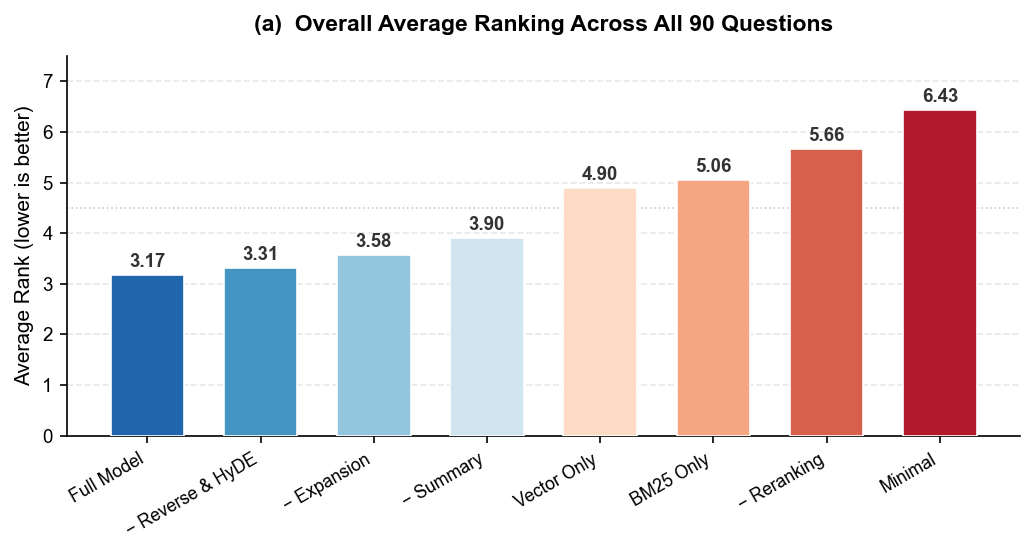

In [14]:
fig, ax = plt.subplots(figsize=(7, 3.8))

x = np.arange(len(sorted_configs))
y = [overall_avg_ranks[c] for c in sorted_configs]
colors = [CONFIG_COLORS[c] for c in sorted_configs]

bars = ax.bar(x, y, width=0.65, color=colors, edgecolor="white", linewidth=0.8, zorder=3)

for bar, val in zip(bars, y):
    ax.text(
        bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.08,
        f"{val:.2f}", ha="center", va="bottom",
        fontsize=9, fontweight="bold", color="#333333"
    )

ax.set_xticks(x)
ax.set_xticklabels([CONFIG_DISPLAY[c] for c in sorted_configs], rotation=30, ha="right", fontsize=8.5)
ax.set_ylabel("Average Rank (lower is better)", fontsize=10)
ax.set_ylim(0, 7.5)
ax.set_title("(a)  Overall Average Ranking Across All 90 Questions", fontsize=11, fontweight="bold", pad=12)
ax.yaxis.grid(True, alpha=0.3, linestyle="--", zorder=0)
ax.set_axisbelow(True)
ax.axhline(y=4.5, color="#999999", linestyle=":", linewidth=0.8, alpha=0.5)

plt.tight_layout()
plt.savefig(EVAL_DATA_DIR / "fig_a_overall_ranking.png", dpi=300)
plt.show()

- 图 (b)：各配置在 7 个评估维度上的排名热力图

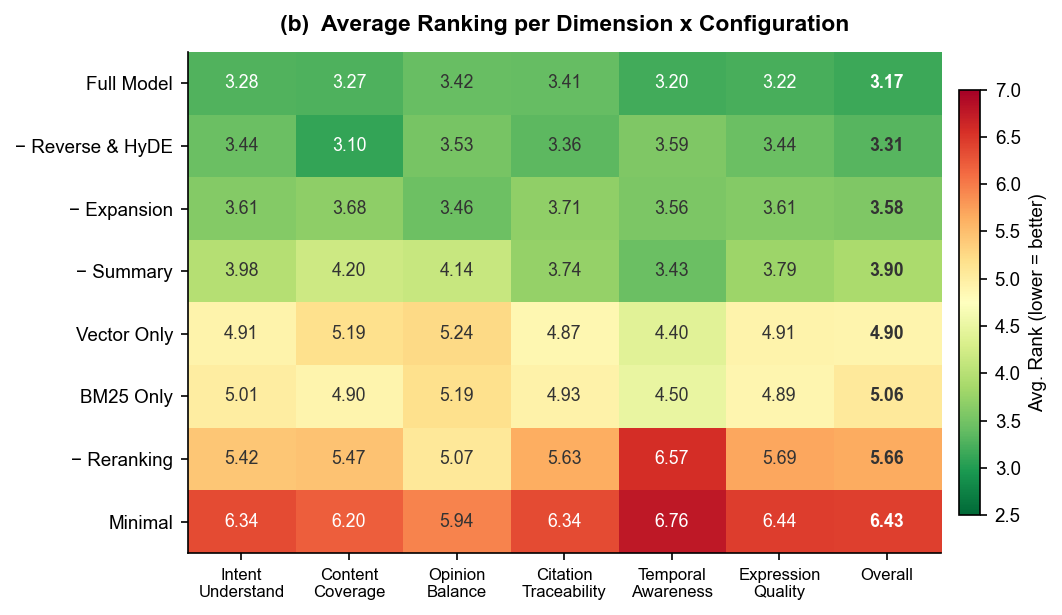

In [15]:
heatmap_data = np.zeros((len(sorted_configs), len(DIMENSIONS)))
for i, config in enumerate(sorted_configs):
    for j, dim in enumerate(DIMENSIONS):
        ranks = [
            r["rankings"][dim][config]
            for r in ranking_results
            if r and r["rankings"] and dim in r["rankings"]
        ]
        heatmap_data[i, j] = np.mean(ranks)

fig, ax = plt.subplots(figsize=(7.5, 4.2))

cmap = plt.colormaps["RdYlGn_r"]
norm = mcolors.Normalize(vmin=2.5, vmax=7.0)
im = ax.imshow(heatmap_data, cmap=cmap, norm=norm, aspect="auto")

for i in range(heatmap_data.shape[0]):
    for j in range(heatmap_data.shape[1]):
        val = heatmap_data[i, j]
        text_color = "white" if val >= 6.0 or val <= 3.3 else "#333333"
        ax.text(
            j, i, f"{val:.2f}",
            ha="center", va="center", fontsize=8.5,
            fontweight="bold" if j == len(DIMENSIONS) - 1 else "normal",
            color=text_color
        )

ax.set_xticks(np.arange(len(DIMENSIONS)))
ax.set_xticklabels(DIM_DISPLAY, fontsize=8, ha="center")
ax.set_yticks(np.arange(len(sorted_configs)))
ax.set_yticklabels([CONFIG_DISPLAY[c] for c in sorted_configs], fontsize=9)
ax.set_title("(b)  Average Ranking per Dimension x Configuration", fontsize=11, fontweight="bold", pad=10)

cbar = fig.colorbar(im, ax=ax, shrink=0.85, pad=0.02)
cbar.set_label("Avg. Rank (lower = better)", fontsize=9)

plt.tight_layout()
plt.savefig(EVAL_DATA_DIR / "fig_b_heatmap.png", dpi=300)
plt.show()

- 图 (c)：结构化问题 vs. 模糊性问题综合排名对比

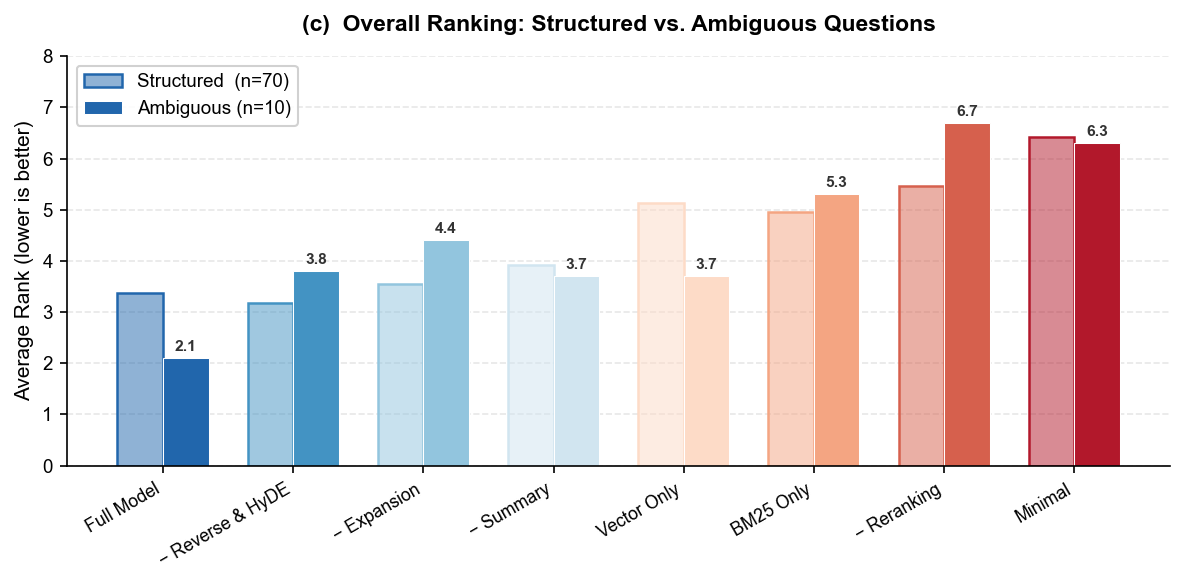

In [16]:
qtype_ranks = {}
for qt in ["structured", "ambiguous"]:
    qtype_ranks[qt] = []
    for config in sorted_configs:
        ranks = [
            r["rankings"]["overall"][config]
            for r in ranking_results
            if r and r["rankings"] and get_question_type(r["question_id"]) == qt
        ]
        qtype_ranks[qt].append(np.mean(ranks))

fig, ax = plt.subplots(figsize=(8, 4))

x = np.arange(len(sorted_configs))
width = 0.35
colors = [CONFIG_COLORS[c] for c in sorted_configs]

bars_s = ax.bar(
    x - width / 2, qtype_ranks["structured"], width,
    label="Structured  (n=70)",
    color=[mcolors.to_rgba(c, 0.5) for c in colors],
    edgecolor=colors, linewidth=1.2
)
bars_a = ax.bar(
    x + width / 2, qtype_ranks["ambiguous"], width,
    label="Ambiguous (n=10)",
    color=colors, edgecolor="white", linewidth=0.5
)

for bar, val in zip(bars_a, qtype_ranks["ambiguous"]):
    ax.text(
        bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.08,
        f"{val:.1f}", ha="center", va="bottom",
        fontsize=7.5, fontweight="bold", color="#333333"
    )

ax.set_xticks(x)
ax.set_xticklabels([CONFIG_DISPLAY[c] for c in sorted_configs], rotation=30, ha="right", fontsize=8.5)
ax.set_ylabel("Average Rank (lower is better)", fontsize=10)
ax.set_ylim(0, 8.0)
ax.set_title("(c)  Overall Ranking: Structured vs. Ambiguous Questions", fontsize=11, fontweight="bold", pad=12)
ax.legend(loc="upper left", framealpha=0.9, fontsize=9)
ax.yaxis.grid(True, alpha=0.3, linestyle="--", zorder=0)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig(EVAL_DATA_DIR / "fig_c_structured_vs_ambiguous.png", dpi=300)
plt.show()

- 图 (d)：各组件贡献度分析

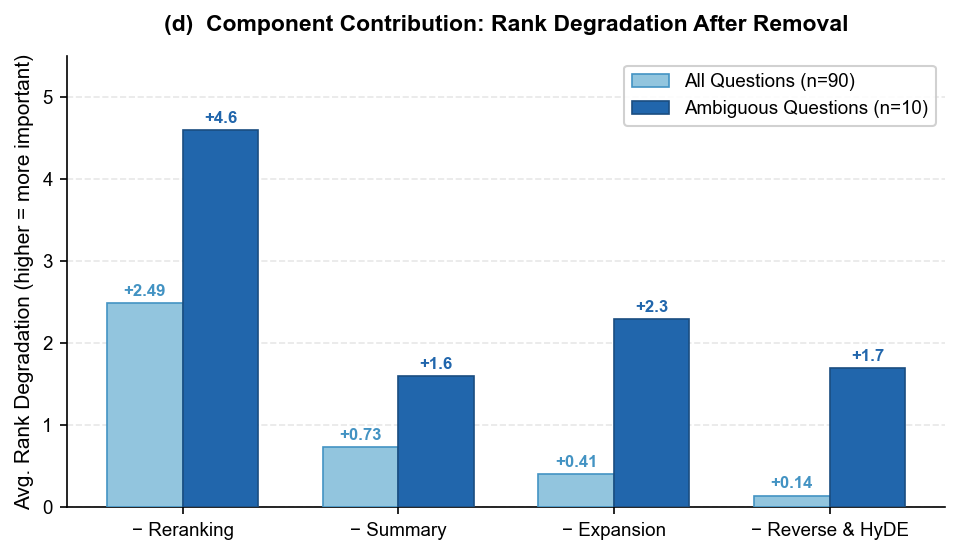

In [17]:
ablation_pairs = [
    ("no_rerank",      "\u2212 Reranking"),
    ("no_summary",     "\u2212 Summary"),
    ("no_expansion",   "\u2212 Expansion"),
    ("no_enhancement", "\u2212 Reverse & HyDE"),
]

all_deltas, amb_deltas = [], []
for config, _ in ablation_pairs:
    d_all = [
        r["rankings"]["overall"][config] - r["rankings"]["overall"]["full"]
        for r in ranking_results if r and r["rankings"]
    ]
    d_amb = [
        r["rankings"]["overall"][config] - r["rankings"]["overall"]["full"]
        for r in ranking_results
        if r and r["rankings"] and get_question_type(r["question_id"]) == "ambiguous"
    ]
    all_deltas.append(np.mean(d_all))
    amb_deltas.append(np.mean(d_amb))

fig, ax = plt.subplots(figsize=(6.5, 3.8))

x = np.arange(len(ablation_pairs))
width = 0.35

bars_all = ax.bar(
    x - width / 2, all_deltas, width,
    label="All Questions (n=90)",
    color="#92C5DE", edgecolor="#4393C3", linewidth=0.8, zorder=3
)
bars_amb = ax.bar(
    x + width / 2, amb_deltas, width,
    label="Ambiguous Questions (n=10)",
    color="#2166AC", edgecolor="#1A4D80", linewidth=0.8, zorder=3
)

for bar, val in zip(bars_all, all_deltas):
    ax.text(
        bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05,
        f"+{val:.2f}", ha="center", va="bottom",
        fontsize=8, color="#4393C3", fontweight="bold"
    )
for bar, val in zip(bars_amb, amb_deltas):
    ax.text(
        bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05,
        f"+{val:.1f}", ha="center", va="bottom",
        fontsize=8, color="#2166AC", fontweight="bold"
    )

ax.set_xticks(x)
ax.set_xticklabels([label for _, label in ablation_pairs], fontsize=9)
ax.set_ylabel("Avg. Rank Degradation (higher = more important)", fontsize=10)
ax.set_title("(d)  Component Contribution: Rank Degradation After Removal", fontsize=11, fontweight="bold", pad=12)
ax.legend(loc="upper right", framealpha=0.9)
ax.yaxis.grid(True, alpha=0.3, linestyle="--", zorder=0)
ax.set_axisbelow(True)
ax.set_ylim(0, 5.5)

plt.tight_layout()
plt.savefig(EVAL_DATA_DIR / "fig_d_component_contribution.png", dpi=300)
plt.show()

In [18]:
# 列出所有已保存的文件
print("模型评估过程文件清单:")
eval_files = sorted(EVAL_DATA_DIR.glob("*"))
for f in eval_files:
    print(f"  • {f.name}")

模型评估过程文件清单:
  • eval_set.json
  • fig_a_overall_ranking.png
  • fig_b_heatmap.png
  • fig_c_structured_vs_ambiguous.png
  • fig_d_component_contribution.png
  • ranking_results.json
  • responses_full.json
  • responses_minimal.json
  • responses_no_enhancement.json
  • responses_no_expansion.json
  • responses_no_rerank.json
  • responses_no_summary.json
  • responses_only_bm25.json
  • responses_only_vector.json
